# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from datetime import date,timedelta
import matplotlib.pyplot as plt
from pandas import Series
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing, metrics
import seaborn as sns
#from pylab import rcParams
plt.rcParams['figure.figsize'] = 20, 5

# Reading files

In [2]:
air_reserve = pd.read_csv('recruit/air_reserve.csv')
hpg_reserve = pd.read_csv('recruit/hpg_reserve.csv')
air_info = pd.read_csv('recruit/air_store_info.csv')
hpg_info = pd.read_csv('recruit/hpg_store_info.csv')
air_visit = pd.read_csv('recruit/air_visit_data.csv')
mapping = pd.read_csv('recruit/store_id_relation.csv')
date_info = pd.read_csv('recruit/date_info.csv')
submission = pd.read_csv('recruit/sample_submission.csv')

# Initial Data Exploration

In [3]:
#checking shape
air_visit.shape

(252108, 3)

In [4]:
air_reserve.shape

(92378, 4)

In [5]:
#describing data frame
air_reserve.describe()

,reserve_visitors
count,92378.00
mean,4.48
std,4.92
min,1.00
25%,2.00
50%,3.00
75%,5.00
max,100.00


In [6]:
#checking for nulls
air_reserve.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [7]:
#visually checking the top records
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [8]:
hpg_reserve.shape

(2000320, 4)

In [9]:
hpg_reserve.describe()

,reserve_visitors
count,2000320.00
mean,5.07
std,5.42
min,1.00
25%,2.00
50%,3.00
75%,6.00
max,100.00


In [10]:
hpg_reserve.isnull().sum()

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [11]:
air_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.70,135.20
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.66,139.75


In [12]:
air_info.shape

(829, 5)

In [13]:
air_info.describe()

,latitude,longitude
count,829.00,829.00
mean,35.65,137.42
std,2.08,3.65
min,33.21,130.20
25%,34.70,135.34
50%,35.66,139.69
75%,35.69,139.75
max,44.02,144.27


In [14]:
air_info.isnull().sum()

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

In [15]:
air_info["air_store_id"].unique().shape

(829,)

In [16]:
air_info["air_genre_name"].unique().shape

(14,)

In [17]:
air_info["air_area_name"].unique().shape

(103,)

In [18]:
hpg_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.64,139.67


In [19]:
hpg_info.describe()

,latitude,longitude
count,4690.00,4690.00
mean,35.81,137.68
std,2.14,3.20
min,33.31,130.34
25%,34.69,135.50
50%,35.66,139.50
75%,35.70,139.74
max,43.77,143.71


In [20]:
hpg_info.shape

(4690, 5)

In [21]:
hpg_info.isnull().sum()

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

In [22]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [23]:
air_visit.describe()

,visitors
count,252108.00
mean,20.97
std,16.76
min,1.00
25%,9.00
50%,17.00
75%,29.00
max,877.00


In [24]:
air_visit.shape

(252108, 3)

In [25]:
air_visit["air_store_id"].unique().shape

(829,)

In [31]:
air_visit["visit_date"].unique().shape

(478,)

In [32]:
air_visit["visit_date"].max()

'2017-04-22'

In [33]:
air_visit["visit_date"].min()

'2016-01-01'

In [26]:
air_visit.isnull().sum()

air_store_id    0
visit_date      0
visitors        0
dtype: int64

In [27]:
mapping.describe()

,air_store_id,hpg_store_id
count,150,150
unique,150,150
top,air_fcd4492c83f1c6b9,hpg_e41e0f2c318dd8e4
freq,1,1


In [28]:
mapping.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [29]:
mapping.shape

(150, 2)

In [30]:
mapping.isnull().sum()

air_store_id    0
hpg_store_id    0
dtype: int64

In [7206]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [7207]:
date_info.calendar_date.max()

'2017-05-31'

In [7208]:
date_info.calendar_date.min()

'2016-01-01'

In [7209]:
date_info["calendar_date"].unique().shape

(517,)

In [7210]:
date_info.shape

(517, 3)

In [7211]:
date_info.describe()

,holiday_flg
count,517.00
mean,0.07
std,0.25
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1.00


In [7212]:
date_info.isnull().sum()

calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64

In [7213]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [7214]:
submission.shape

(32019, 2)

In [7215]:
submission.describe()

,visitors
count,32019.00
mean,0.00
std,0.00
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,0.00


In [7216]:
submission.isnull().sum()

id          0
visitors    0
dtype: int64

# Combining files and preparing train

In [7217]:
hpg_reserve["hpg_store_id"].unique().shape

(13325,)

In [7218]:
mapping["hpg_store_id"].unique().shape

(150,)

In [7219]:
#combining hpg reserve data with air store id
hpg_reserve = pd.merge(hpg_reserve,mapping,how='inner',on='hpg_store_id')

In [7220]:
#handling date
air_reserve["visit_date"] = pd.to_datetime(air_reserve["visit_datetime"]).dt.date
air_reserve["reserve_date"] = pd.to_datetime(air_reserve["reserve_datetime"]).dt.date
#grouping reservation information by visit date and air store id
air_reserve = air_reserve.groupby(['air_store_id','visit_date'], as_index=False).agg({'reserve_visitors':'sum'})

In [7221]:
hpg_reserve["visit_date"] = pd.to_datetime(hpg_reserve["visit_datetime"]).dt.date
hpg_reserve["reserve_date"] = pd.to_datetime(hpg_reserve["reserve_datetime"]).dt.date
hpg_reserve = hpg_reserve.groupby(['air_store_id','visit_date'], as_index=False).agg({'reserve_visitors':'sum'})

In [7222]:
#merging dataframes and preparing train

In [7223]:
date_info["visit_date"] = pd.to_datetime(date_info["calendar_date"])

In [7224]:
air_visit['visit_date'] = pd.to_datetime(air_visit.visit_date,format = '%Y-%m-%d')

In [7225]:
air_visit['year'] = air_visit.visit_date.dt.year
air_visit['month'] = air_visit.visit_date.dt.month
air_visit['day'] = air_visit.visit_date.dt.day

In [7226]:
train = pd.merge(air_visit,date_info,how='left',on='visit_date')

In [7227]:
train.drop("calendar_date",axis=1,inplace=True)

In [7228]:
#merging with reservation info
air_reserve["visit_date"] = pd.to_datetime(air_reserve["visit_date"])
hpg_reserve["visit_date"] = pd.to_datetime(hpg_reserve["visit_date"])
train["visit_date"] = pd.to_datetime(train["visit_date"])

In [7229]:
hpg_reserve.head()

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-01-14,2
1,air_00a91d42b08b08d9,2016-01-15,4
2,air_00a91d42b08b08d9,2016-01-16,2
3,air_00a91d42b08b08d9,2016-01-22,2
4,air_00a91d42b08b08d9,2016-01-29,5


In [7230]:
train = pd.merge(train,air_reserve,how='left',on=['air_store_id','visit_date'])
train = pd.merge(train,hpg_reserve,how='left',on=['air_store_id','visit_date'])

In [7231]:
#combining visitor information from both hpg and air
train["reserve_visitors"] = train["reserve_visitors_x"].fillna(0) + train["reserve_visitors_y"].fillna(0) 
train['reserve_visitors'] = train['reserve_visitors'].replace(0, np.nan)
train.drop(["reserve_visitors_x","reserve_visitors_y"],axis=1,inplace=True)

In [7232]:
train = train.merge(air_info,how='left',on='air_store_id')

In [7233]:
train.tail()

,air_store_id,visit_date,visitors,year,month,day,day_of_week,holiday_flg,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
252103,air_24e8414b9b07decb,2017-04-18,6,2017,4,18,Tuesday,0,nan,Other,Tōkyō-to Shibuya-ku Higashi,35.65,139.71
252104,air_24e8414b9b07decb,2017-04-19,6,2017,4,19,Wednesday,0,nan,Other,Tōkyō-to Shibuya-ku Higashi,35.65,139.71
252105,air_24e8414b9b07decb,2017-04-20,7,2017,4,20,Thursday,0,nan,Other,Tōkyō-to Shibuya-ku Higashi,35.65,139.71
252106,air_24e8414b9b07decb,2017-04-21,8,2017,4,21,Friday,0,nan,Other,Tōkyō-to Shibuya-ku Higashi,35.65,139.71
252107,air_24e8414b9b07decb,2017-04-22,5,2017,4,22,Saturday,0,nan,Other,Tōkyō-to Shibuya-ku Higashi,35.65,139.71


In [7234]:
train.shape

(252108, 13)

In [7235]:
train.visit_date.max()

Timestamp('2017-04-22 00:00:00')

In [7236]:
train.visit_date.min()

Timestamp('2016-01-01 00:00:00')

In [7237]:
train.head()

,air_store_id,visit_date,visitors,year,month,day,day_of_week,holiday_flg,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,Wednesday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,Thursday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,Friday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,Saturday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,Monday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75


In [7238]:
cols_to_drop = ["air_store_id",'visit_date','visitors',"year","latitude","longitude"]

In [7239]:
train.head()

,air_store_id,visit_date,visitors,year,month,day,day_of_week,holiday_flg,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,Wednesday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,Thursday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,Friday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,Saturday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,Monday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75


In [7240]:
temp_mean = train.groupby(['air_store_id','day_of_week'], as_index=False)["visitors"].mean()
temp_min = train.groupby(['air_store_id','day_of_week'], as_index=False)["visitors"].min()
temp_max = train.groupby(['air_store_id','day_of_week'], as_index=False)["visitors"].max()

In [7241]:
temp_mean.rename(columns = {"visitors":"mean_visitors"},inplace=True)
temp_min.rename(columns = {"visitors":"min_visitors"},inplace=True)
temp_max.rename(columns = {"visitors":"max_visitors"},inplace=True)

In [7242]:
train = train.merge(temp_mean, how='left', on=['air_store_id','day_of_week'])
train = train.merge(temp_min, how='left', on=['air_store_id','day_of_week'])
train = train.merge(temp_max, how='left', on=['air_store_id','day_of_week'])

In [7243]:
train.head()

,air_store_id,visit_date,visitors,year,month,day,day_of_week,holiday_flg,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,mean_visitors,min_visitors,max_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,2016,1,13,Wednesday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,23.84,7,57
1,air_ba937bf13d40fb24,2016-01-14,32,2016,1,14,Thursday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,20.29,2,54
2,air_ba937bf13d40fb24,2016-01-15,29,2016,1,15,Friday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,34.74,4,61
3,air_ba937bf13d40fb24,2016-01-16,22,2016,1,16,Saturday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,27.65,6,53
4,air_ba937bf13d40fb24,2016-01-18,6,2016,1,18,Monday,0,nan,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.66,139.75,13.75,2,34


In [7244]:
train.shape

(252108, 16)

In [7245]:
train.describe()

,visitors,year,month,day,holiday_flg,reserve_visitors,latitude,longitude,mean_visitors,min_visitors,max_visitors
count,252108.00,252108.00,252108.00,252108.00,252108.00,35698.00,252108.00,252108.00,252108.00,252108.00,252108.00
mean,20.97,2016.31,6.21,15.59,0.05,13.39,35.61,137.36,20.97,5.35,49.81
std,16.76,0.46,3.68,8.67,0.22,17.14,2.04,3.67,12.56,6.38,37.22
min,1.00,2016.00,1.00,1.00,0.00,1.00,33.21,130.20,1.00,1.00,1.00
25%,9.00,2016.00,3.00,8.00,0.00,4.00,34.69,135.34,11.16,1.00,28.00
50%,17.00,2016.00,7.00,16.00,0.00,9.00,35.66,139.67,18.39,3.00,43.00
75%,29.00,2017.00,10.00,23.00,0.00,18.00,35.69,139.75,28.10,7.00,63.00
max,877.00,2017.00,12.00,31.00,1.00,1633.00,44.02,144.27,147.43,132.00,877.00


In [7246]:
train.isnull().sum()

air_store_id             0
visit_date               0
visitors                 0
year                     0
month                    0
day                      0
day_of_week              0
holiday_flg              0
reserve_visitors    216410
air_genre_name           0
air_area_name            0
latitude                 0
longitude                0
mean_visitors            0
min_visitors             0
max_visitors             0
dtype: int64

# Data Visualization

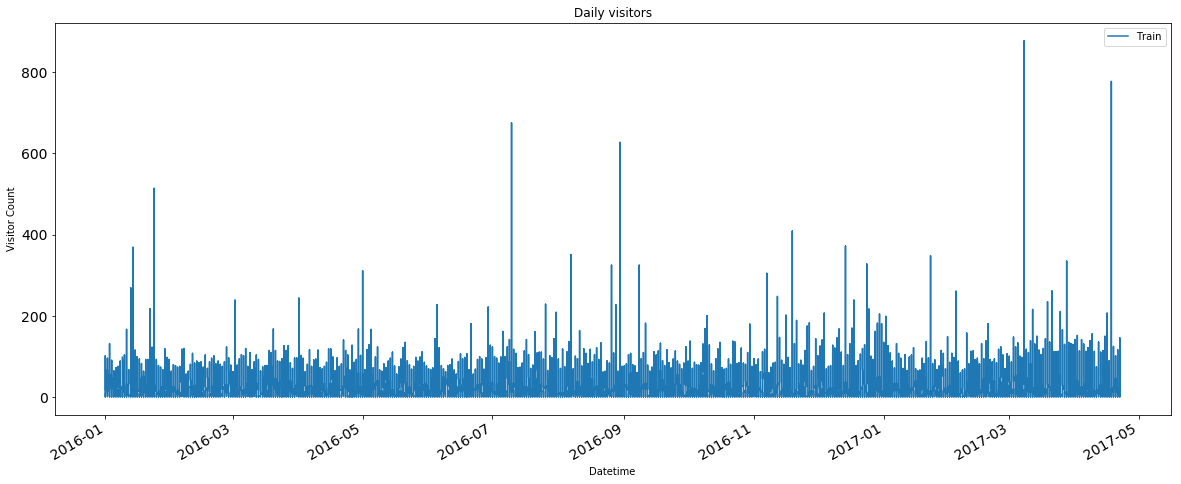

In [7247]:
#Visual inspection to see if the data is stationary
train.index = train['visit_date']
train.visitors.plot(figsize = (20,8), title = 'Daily visitors', fontsize = 14, label = 'Train')
plt.xlabel('Datetime')
plt.ylabel('Visitor Count')
plt.legend(loc = 'best')

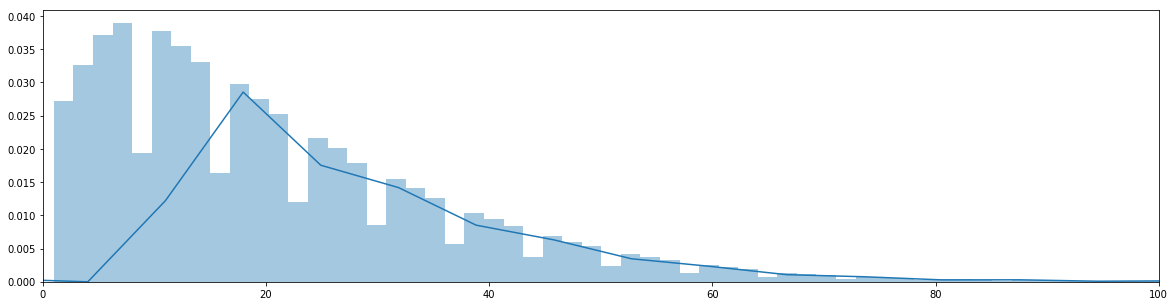

In [7248]:
#plotting to see the distribution of visitors 
plt.xlim(0, 100)
sns.distplot(train["visitors"].values,bins=500)

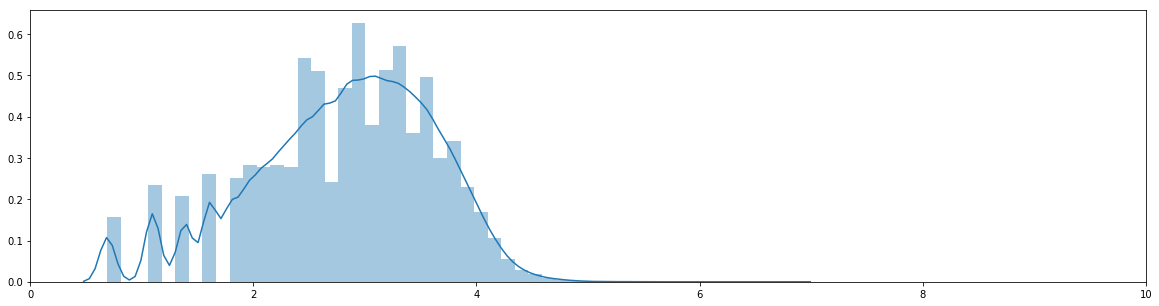

In [7249]:
#converting to log and the distribution becomes more normal
plt.xlim(0, 10)
sns.distplot(np.log1p(train["visitors"]).values,bins=50)

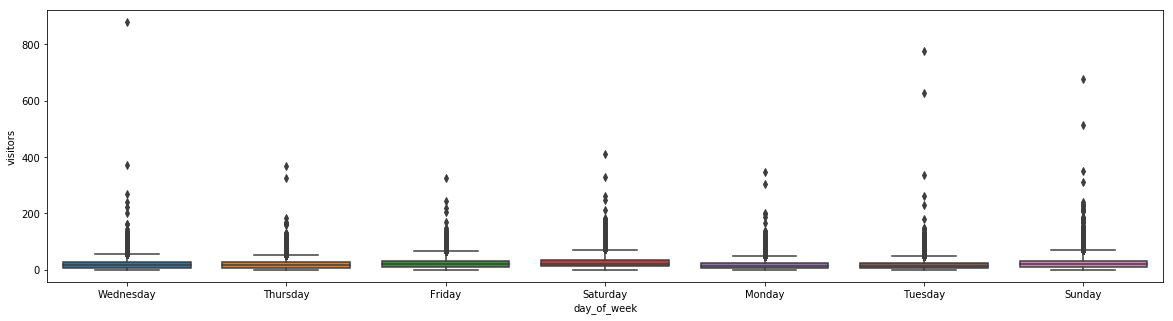

In [7250]:
#bot plot showing distribution of visitors per day of the week
sns.boxplot(train["day_of_week"],train["visitors"])

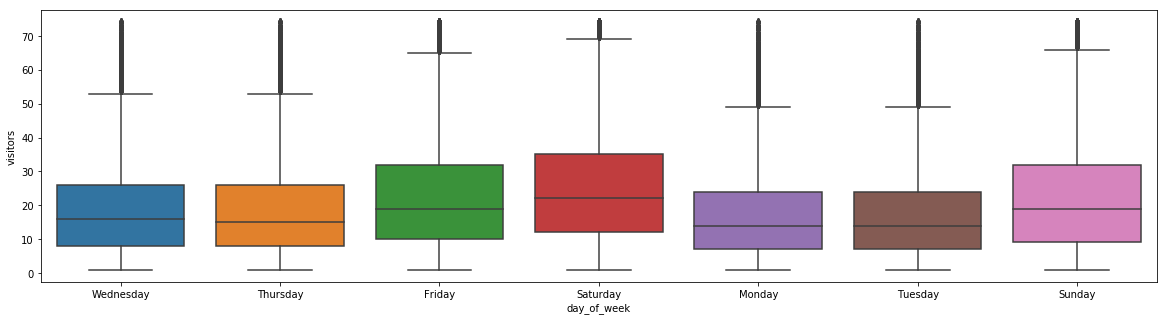

In [7251]:
sns.boxplot(train[train["visitors"]<75]["day_of_week"],train[train["visitors"]<75]["visitors"])

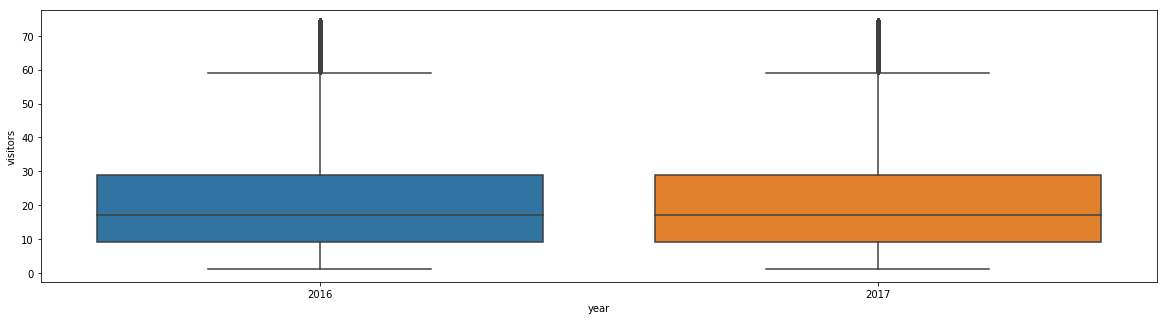

In [7252]:
sns.boxplot(train[train["visitors"]<75]["year"],train[train["visitors"]<75]["visitors"])

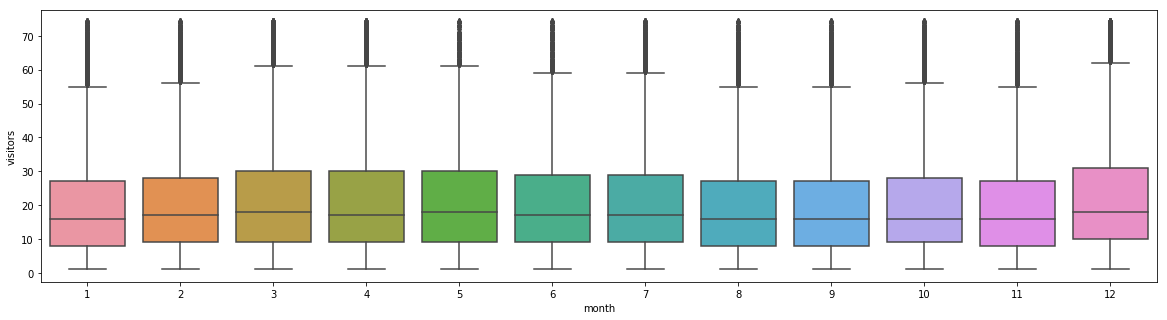

In [7253]:
sns.boxplot(train[train["visitors"]<75]["month"],train[train["visitors"]<75]["visitors"])

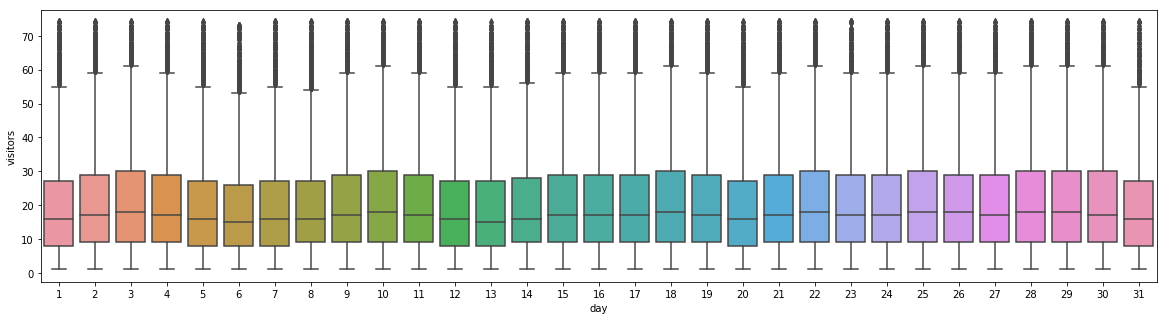

In [7254]:
sns.boxplot(train[train["visitors"]<75]["day"],train[train["visitors"]<75]["visitors"])

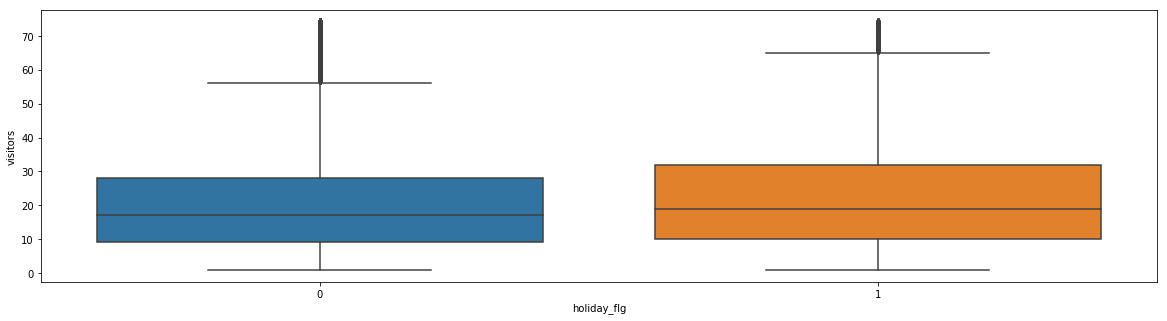

In [7255]:
sns.boxplot(train[train["visitors"]<75]["holiday_flg"],train[train["visitors"]<75]["visitors"])

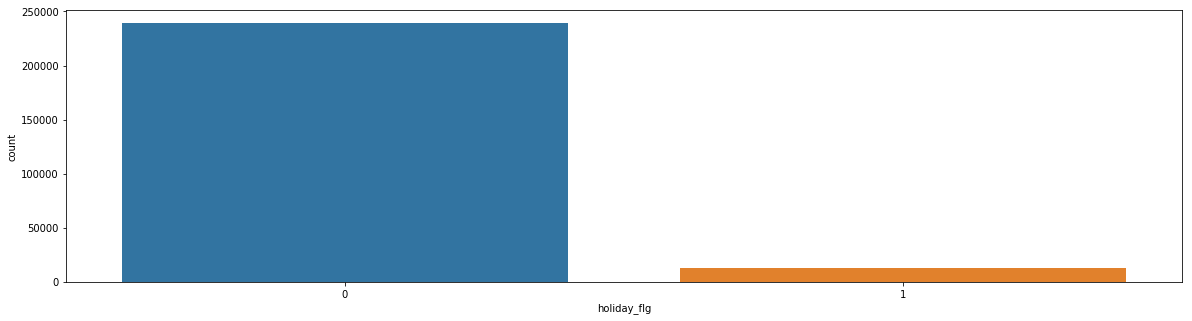

In [7256]:
#count of instances
sns.countplot(x="holiday_flg",data=train)

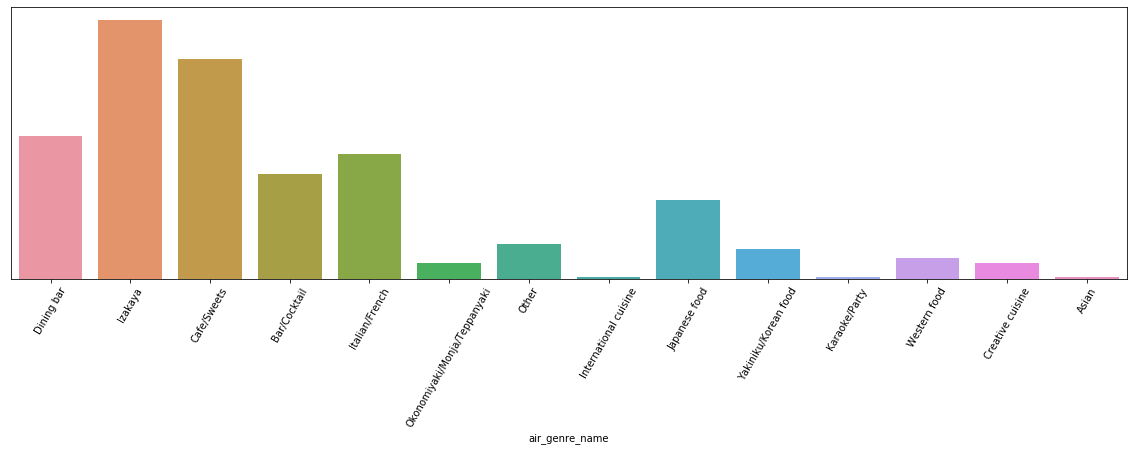

In [7257]:
ax = sns.countplot(x="air_genre_name",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.axes.get_yaxis().set_visible(False)

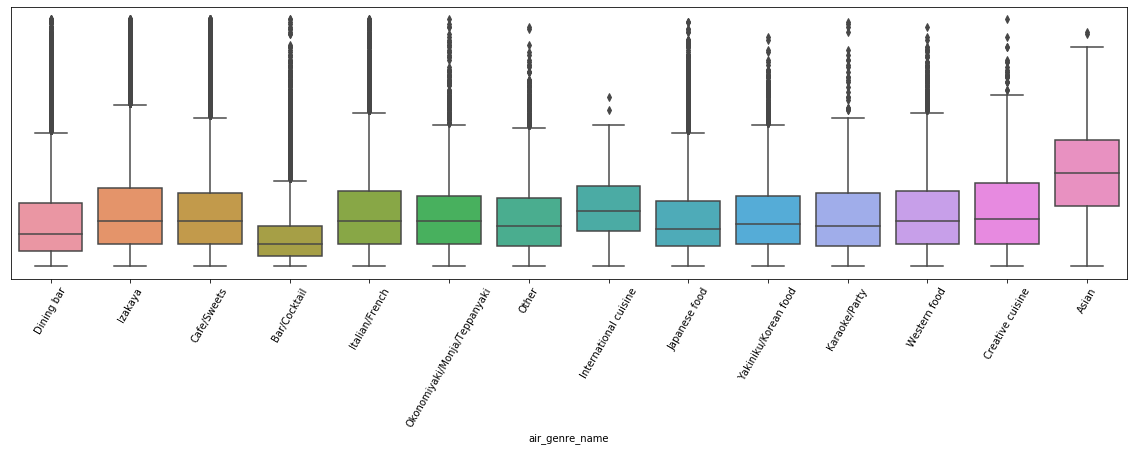

In [7258]:
ax = sns.boxplot(train[train["visitors"]<100]["air_genre_name"],train[train["visitors"]<100]["visitors"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.axes.get_yaxis().set_visible(False)

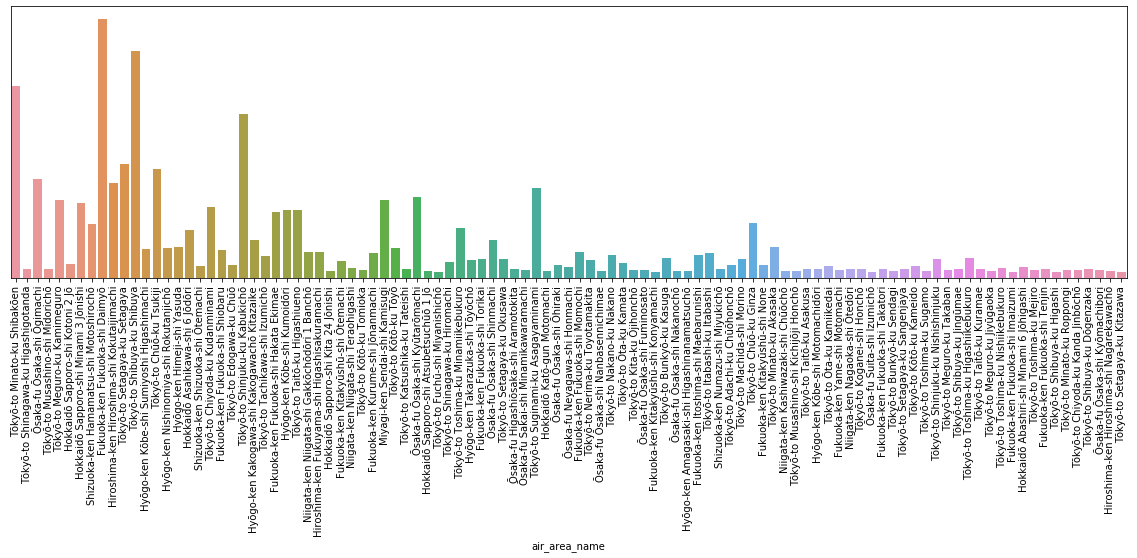

In [7259]:
ax = sns.countplot(x="air_area_name",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.get_yaxis().set_visible(False)

In [7260]:
train["air_area_name"].value_counts().shape[0]

103

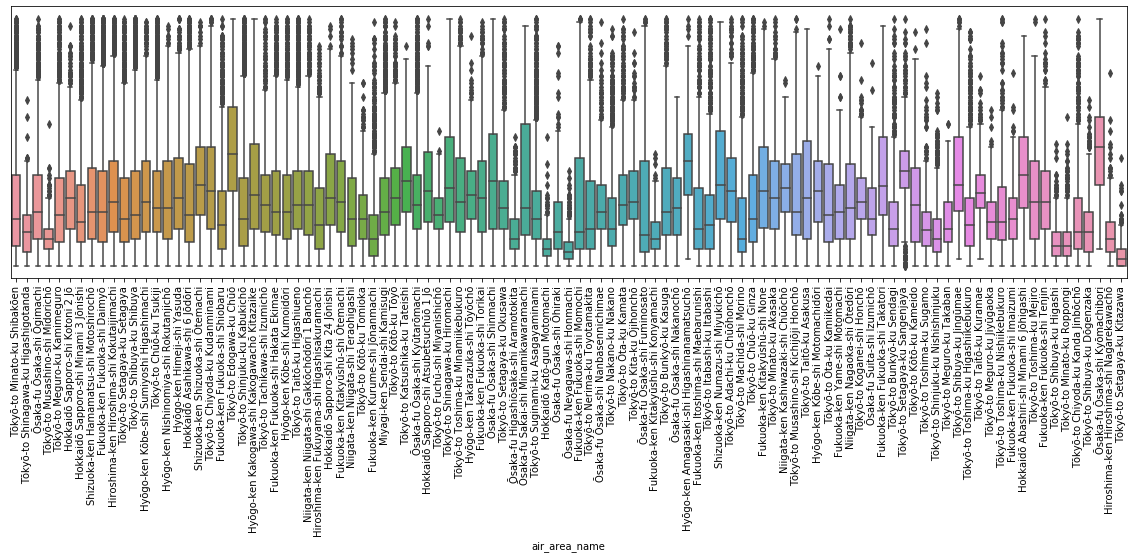

In [7261]:
ax = sns.boxplot(train[train["visitors"]<75]["air_area_name"],train[train["visitors"]<75]["visitors"])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
#ax.axes.get_yaxis().set_visible(False)

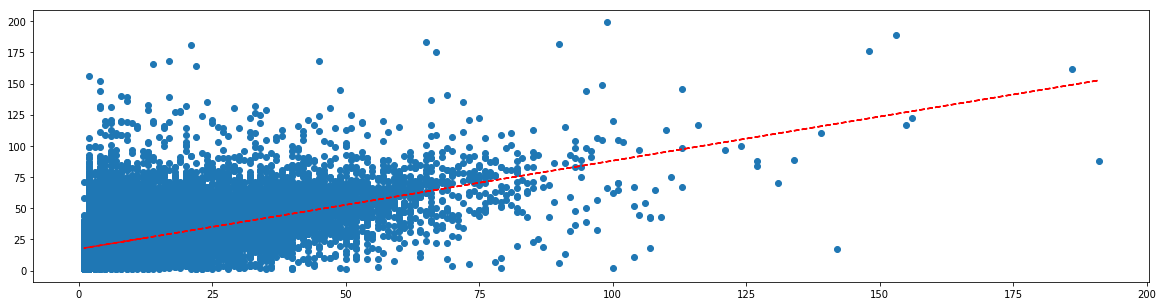

In [7262]:
x = train[(train["visitors"]<200) & (train["reserve_visitors"]<200)]["reserve_visitors"]
y = train[(train["visitors"]<200) & (train["reserve_visitors"]<200)]["visitors"]
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

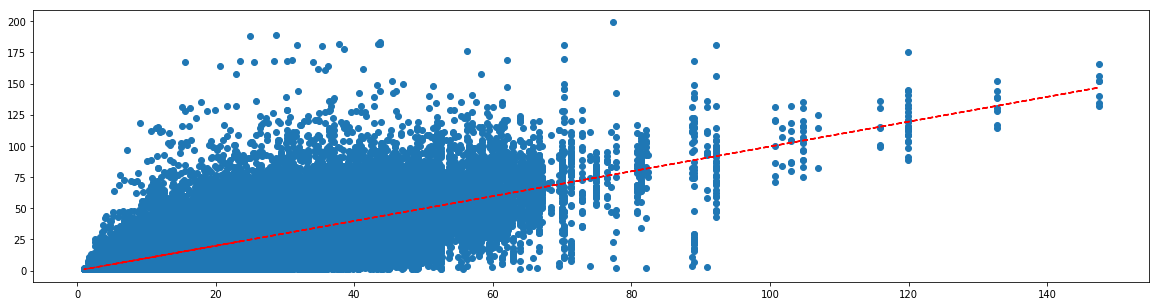

In [7263]:
x = train[(train["visitors"]<200) & (train["mean_visitors"]<200)]["mean_visitors"]
y = train[(train["visitors"]<200) & (train["mean_visitors"]<200)]["visitors"]
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

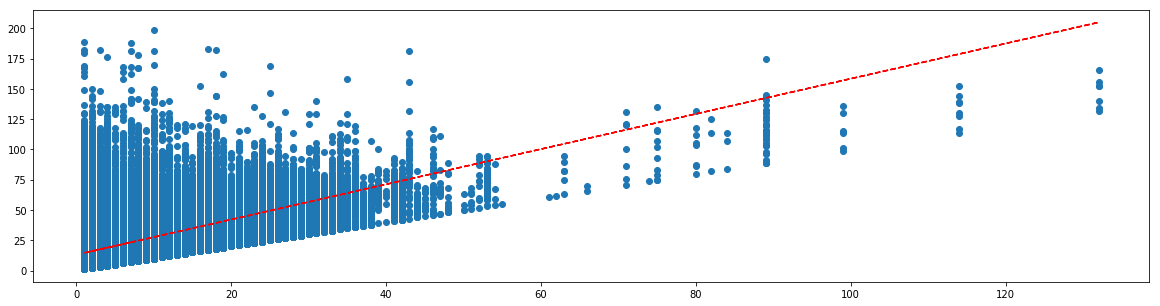

In [7264]:
x = train[(train["visitors"]<200)]["min_visitors"]
y = train[(train["visitors"]<200)]["visitors"]
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

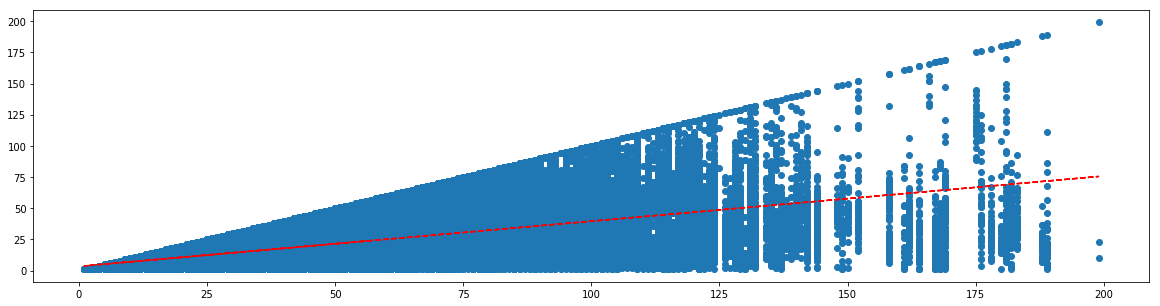

In [7265]:
x = train[(train["visitors"]<200) & (train["max_visitors"]<200)]["max_visitors"]
y = train[(train["visitors"]<200) & (train["max_visitors"]<200)]["visitors"]
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(x,p(x),"r--")

plt.show()

# Handling categorical features

In [7266]:
train['air_area_name'].value_counts().shape

(103,)

In [7267]:
train['air_genre_name'].value_counts().shape

(14,)

In [7268]:
#one hot encoding
train = pd.get_dummies(train, columns=['day_of_week', 'air_genre_name'])

In [7269]:
#Using Label encoder for air area name
Encoder = preprocessing.LabelEncoder()
train['air_area_name'] = Encoder.fit_transform(train['air_area_name'])
train['air_area_name'] = train['air_area_name'].astype('category')

# Modelling and Cross Validation

In [7270]:
#this is optimized now
params = {
    'learning_rate':[0.05],
    'num_leaves':[325,350],
    'boosting_type':['gbdt'],
    'metric':'rmse',
    'objective':['regression'],
    'max_depth':[7],
    'sub_feature':[0.7],
    'subsample':[0.5],
    'min_child_samples':[80]
}

In [7271]:
clf = lgb.LGBMRegressor()

In [7272]:
grid = RandomizedSearchCV(clf,params,verbose=1,cv=5,n_jobs=-1,n_iter=5)

In [7273]:
#cross validation

In [7274]:
#preparing training data set
train_X = train[train.visit_date < '2017-03-01']

In [7275]:
#preparing validation data set
val_X = train[train.visit_date >= '2017-03-01']

In [7276]:
train_X.shape

(214046, 35)

In [7277]:
val_X.shape

(38062, 35)

In [7278]:
train.shape

(252108, 35)

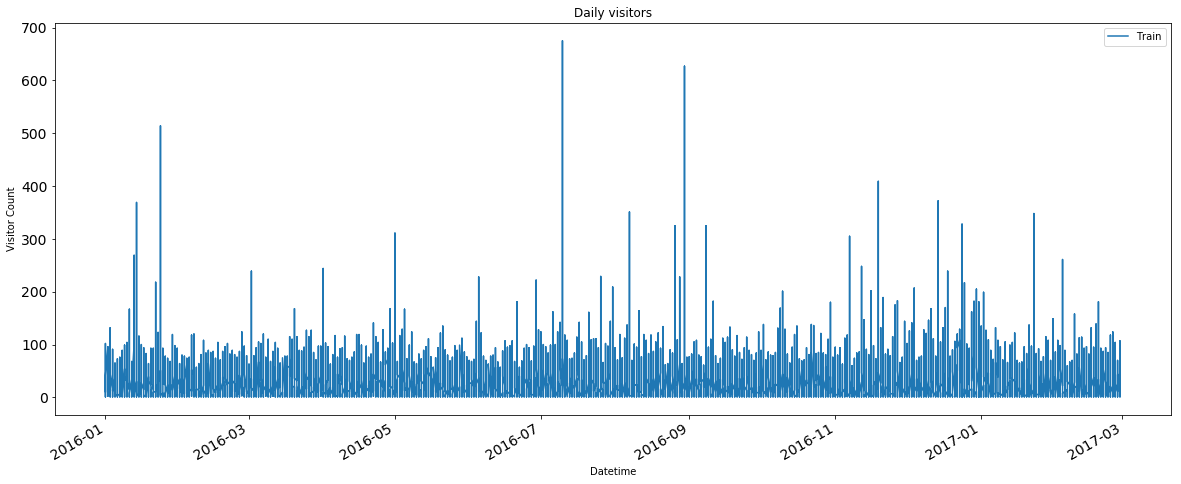

In [7279]:
#verifying the distribution of training
train_X.index = train_X['visit_date']
train_X.visitors.plot(figsize = (20,8), title = 'Daily visitors', fontsize = 14, label = 'Train')
plt.xlabel('Datetime')
plt.ylabel('Visitor Count')
plt.legend(loc = 'best')

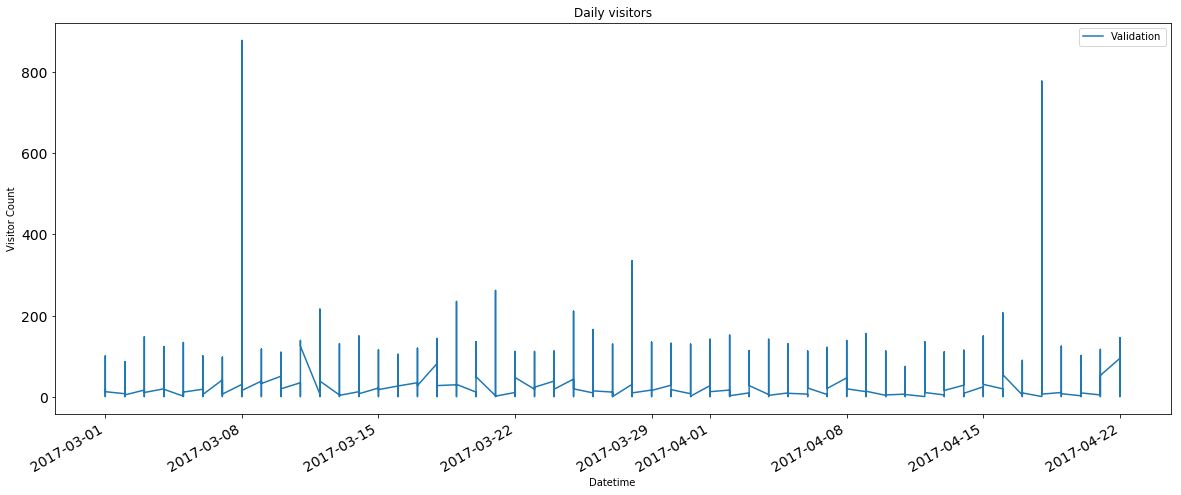

In [7280]:
#verifying the distribution of validation
val_X.index = val_X['visit_date']
val_X.visitors.plot(figsize = (20,8), title = 'Daily visitors', fontsize = 14, label = 'Validation')
plt.xlabel('Datetime')
plt.ylabel('Visitor Count')
plt.legend(loc = 'best')

In [7281]:
grid.fit(train_X.drop(cols_to_drop,axis=1),np.log1p(train_X["visitors"]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'learning_rate': [0.05], 'num_leaves': [325, 350], 'boosting_type': ['gbdt'], 'metric': 'rmse', 'objective': ['regression'], 'max_depth': [7], 'sub_feature': [0.7], 'subsample': [0.5], 'min_child_samples': [80]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [7282]:
pred_y = np.expm1(grid.predict(val_X.drop(cols_to_drop,axis=1)))
train_y = np.expm1(grid.predict(train_X.drop(cols_to_drop,axis=1)))

In [7283]:
grid.best_params_

{'subsample': 0.5,
 'sub_feature': 0.7,
 'objective': 'regression',
 'num_leaves': 350,
 'min_child_samples': 80,
 'metric': 's',
 'max_depth': 7,
 'learning_rate': 0.05,
 'boosting_type': 'gbdt'}

In [7284]:
#calulating RMSLE Score for cross validation
RMSLE_test = np.round(metrics.mean_squared_error(np.log1p(val_X["visitors"]),np.log1p(pred_y))**0.5,2)
RMSLE_train = np.round(metrics.mean_squared_error(np.log1p(train_X["visitors"]),np.log1p(train_y))**0.5,2)

In [7285]:
print("Training RMSLE = {}".format(RMSLE_train))

Training RMSLE = 0.5


In [7286]:
print("Testing RMSLE = {}".format(RMSLE_test))

Testing RMSLE = 0.51


# Feature Importance

In [34]:
#Plotting feature importance
predictors = [x for x in train_X.drop(cols_to_drop,axis=1).columns]
feat_imp = pd.Series(grid.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
#feat_imp = feat_imp[0:20]
plt.rcParams['figure.figsize'] = 20, 5
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

NameError: name 'train_X' is not defined

# Preparing test

In [7288]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [7289]:
submission["visit_date"] = submission["id"].map(lambda x:str(x).split('_')[2])
submission["air_store_id"] = submission["id"].map(lambda x: '_'.join(x.split('_')[:2]))
#test = submission[["air_store_id","visit_date","visitors"]].copy()

In [7290]:
submission['visit_date'] = pd.to_datetime(submission.visit_date,format = '%Y-%m-%d')
submission['year'] = submission.visit_date.dt.year
submission['month'] = submission.visit_date.dt.month
submission['day'] = submission.visit_date.dt.day

In [7291]:
test = pd.merge(submission,date_info,how='left',on='visit_date')

In [7292]:
test.head()

,id,visitors,visit_date,air_store_id,year,month,day,calendar_date,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,2017,4,23,2017-04-23,Sunday,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,2017,4,24,2017-04-24,Monday,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,2017,4,25,2017-04-25,Tuesday,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2017,4,26,2017-04-26,Wednesday,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,2017,4,27,2017-04-27,Thursday,0


In [7293]:
test_cols_to_drop = cols_to_drop + ["id","calendar_date"]

In [7294]:
test = pd.merge(test,air_reserve,how='left',on=['air_store_id','visit_date'])
test = pd.merge(test,hpg_reserve,how='left',on=['air_store_id','visit_date'])

In [7295]:
test["reserve_visitors"] = test["reserve_visitors_x"].fillna(0) + test["reserve_visitors_y"].fillna(0) 
test['reserve_visitors'] = test['reserve_visitors'].replace(0, np.nan)
test.drop(["reserve_visitors_x","reserve_visitors_y"],axis=1,inplace=True)

In [7296]:
test = test.merge(air_info,how='left',on='air_store_id')

In [7297]:
test = test.merge(temp_mean, how='left', on=['air_store_id','day_of_week'])
test = test.merge(temp_min, how='left', on=['air_store_id','day_of_week'])
test = test.merge(temp_max, how='left', on=['air_store_id','day_of_week'])

In [7298]:
test.head()

,id,visitors,visit_date,air_store_id,year,month,day,calendar_date,day_of_week,holiday_flg,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,mean_visitors,min_visitors,max_visitors
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,2017,4,23,2017-04-23,Sunday,0,nan,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.69,139.75,2.00,2.00,2.00
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,2017,4,24,2017-04-24,Monday,0,nan,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.69,139.75,22.46,1.00,47.00
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,2017,4,25,2017-04-25,Tuesday,0,nan,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.69,139.75,24.35,1.00,43.00
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2017,4,26,2017-04-26,Wednesday,0,nan,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.69,139.75,28.12,15.00,52.00
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,2017,4,27,2017-04-27,Thursday,0,nan,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.69,139.75,29.87,15.00,47.00


In [7299]:
test["visit_date"].max()

Timestamp('2017-05-31 00:00:00')

In [7300]:
test["visit_date"].min()

Timestamp('2017-04-23 00:00:00')

In [7301]:
test.shape

(32019, 18)

In [7302]:
test.isnull().sum()

id                      0
visitors                0
visit_date              0
air_store_id            0
year                    0
month                   0
day                     0
calendar_date           0
day_of_week             0
holiday_flg             0
reserve_visitors    30750
air_genre_name          0
air_area_name           0
latitude                0
longitude               0
mean_visitors         341
min_visitors          341
max_visitors          341
dtype: int64

In [7303]:
test.describe()

,visitors,year,month,day,holiday_flg,reserve_visitors,latitude,longitude,mean_visitors,min_visitors,max_visitors
count,32019.00,32019.00,32019.00,32019.00,32019.00,1269.00,32019.00,32019.00,31678.00,31678.00,31678.00
mean,0.00,2017.00,4.79,18.15,0.10,10.92,35.63,137.41,20.35,5.54,47.53
std,0.00,0.00,0.40,9.09,0.30,17.61,2.06,3.64,13.49,7.78,37.34
min,0.00,2017.00,4.00,1.00,0.00,1.00,33.21,130.20,1.00,1.00,1.00
25%,0.00,2017.00,5.00,10.00,0.00,4.00,34.70,135.34,10.29,1.00,26.00
50%,0.00,2017.00,5.00,20.00,0.00,6.00,35.66,139.68,17.42,2.00,41.00
75%,0.00,2017.00,5.00,26.00,0.00,13.00,35.69,139.75,27.36,7.00,61.00
max,0.00,2017.00,5.00,31.00,1.00,511.00,44.02,144.27,147.43,132.00,877.00


In [7304]:
#handling categorical values for test

In [7305]:
test = pd.get_dummies(test,columns=['day_of_week', 'air_genre_name'])

In [7306]:
#transforming air_area_name for test
test["air_area_name"] = Encoder.transform(test["air_area_name"])
test['air_area_name'] = test['air_area_name'].astype('category')

# Prediction and Submission

In [7307]:
test["visitors"] = np.round(np.expm1(grid.predict(test.drop(test_cols_to_drop,axis=1))),2)

In [7308]:
test["visitors"].head(5)

0    1.66
1   19.15
2   22.30
3   28.56
4   30.58
Name: visitors, dtype: float64

In [7309]:
submission = test[["id","visitors"]].copy()
submission.to_csv("submission.csv",index=False)